In [2]:
!pip install h5py

In [14]:
!pip install joblib

In [15]:
import h5py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F

총 2000개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 2000

SBP (수축기 혈압):
  - 평균: 102.15 mmHg
  - 최소: 82.78 mmHg
  - 최대: 116.47 mmHg
  - 표준편차: 2.00 mmHg

DBP (이완기 혈압):
  - 평균: 46.15 mmHg
  - 최소: 40.65 mmHg
  - 최대: 54.42 mmHg
  - 표준편차: 1.45 mmHg


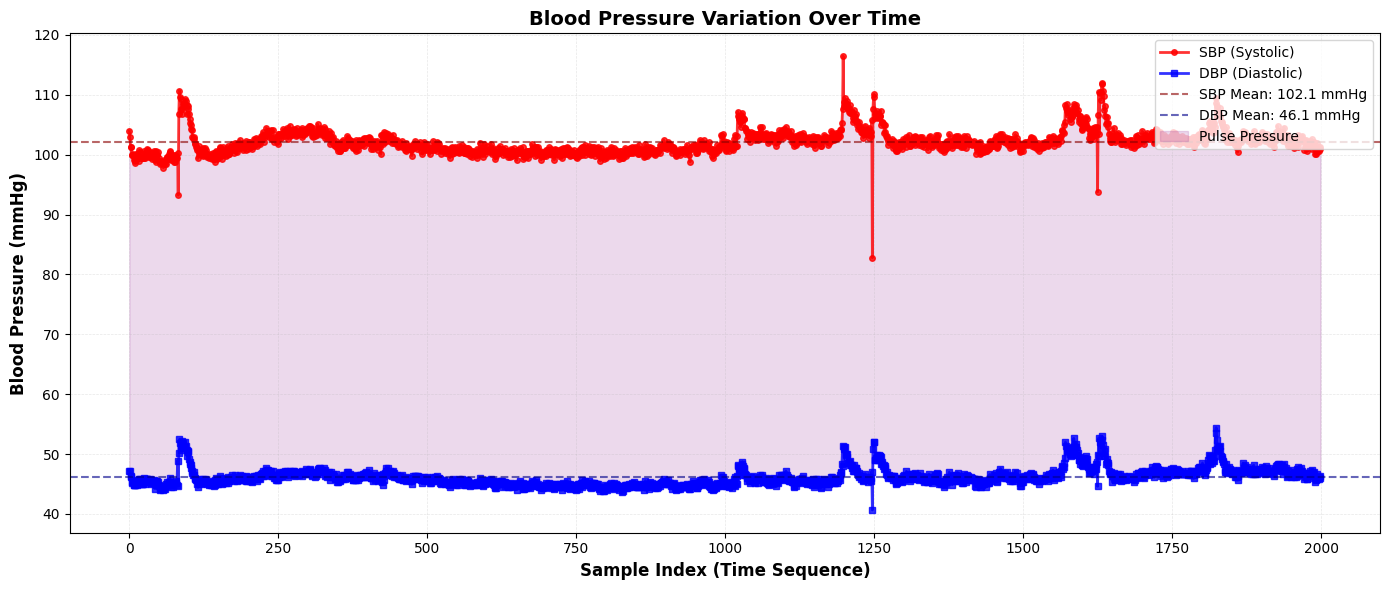


로드 완료: 2000개의 PPG 세그먼트


In [19]:
def load_and_display_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG 세그먼트와 혈압(SBP, DBP) 데이터를 로드하고 표시

    Args:
        mat_path: .mat 파일 경로
        segment_limit: 로드할 최대 세그먼트 수 (None이면 전체)
    """
    segments, sbp_list, dbp_list = [], [], []

    # MAT 파일 로드
    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)

        print(f"총 {total}개의 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 통계 출력
    print(f"\n=== 혈압 데이터 통계 ===")
    print(f"세그먼트 수: {len(segments)}")
    print(f"\nSBP (수축기 혈압):")
    print(f"  - 평균: {np.mean(sbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(sbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(sbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(sbp_list):.2f} mmHg")

    print(f"\nDBP (이완기 혈압):")
    print(f"  - 평균: {np.mean(dbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(dbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(dbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(dbp_list):.2f} mmHg")

    # 시각화
    plot_bp_combined_timeseries(sbp_list, dbp_list)

    return segments, sbp_list, dbp_list


def plot_bp_distribution(sbp_list, dbp_list):
    """혈압 분포 히스토그램"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(sbp_list, bins=30, color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('SBP (mmHg)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SBP Distribution')
    ax1.axvline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(dbp_list, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('DBP (mmHg)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('DBP Distribution')
    ax2.axvline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_scatter(sbp_list, dbp_list):
    """SBP vs DBP 산점도"""
    plt.figure(figsize=(8, 6))
    plt.scatter(sbp_list, dbp_list, alpha=0.6, s=50, c=range(len(sbp_list)),
                cmap='viridis', edgecolors='black', linewidth=0.5)

    plt.xlabel('SBP (mmHg)', fontsize=12)
    plt.ylabel('DBP (mmHg)', fontsize=12)
    plt.title('SBP vs DBP Relationship', fontsize=14)
    plt.colorbar(label='Sample Index')
    plt.grid(alpha=0.3)

    # 추세선
    z = np.polyfit(sbp_list, dbp_list, 1)
    p = np.poly1d(z)
    plt.plot(sorted(sbp_list), p(sorted(sbp_list)), "r--",
             linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_bp_timeseries(sbp_list, dbp_list):
    """시간 순서에 따른 SBP/DBP 변화 그래프"""
    time_idx = np.arange(len(sbp_list))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # SBP 시계열
    ax1.plot(time_idx, sbp_list, color='red', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='SBP')
    ax1.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.fill_between(time_idx, sbp_list, alpha=0.2, color='red')
    ax1.set_ylabel('SBP (mmHg)', fontsize=12, fontweight='bold')
    ax1.set_title('Systolic Blood Pressure Over Time', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)

    # DBP 시계열
    ax2.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='DBP')
    ax2.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.fill_between(time_idx, dbp_list, alpha=0.2, color='blue')
    ax2.set_xlabel('Sample Index (Time Sequence)', fontsize=12)
    ax2.set_ylabel('DBP (mmHg)', fontsize=12, fontweight='bold')
    ax2.set_title('Diastolic Blood Pressure Over Time', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_combined_timeseries(sbp_list, dbp_list):
    """SBP와 DBP를 하나의 그래프에 표시 (흰색 배경)"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(14, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=2,
            marker='o', markersize=4, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=2,
            marker='s', markersize=4, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.15, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Sample Index (Time Sequence)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Pressure Variation Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # 배경색 명시적으로 흰색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()


def plot_sample_ppg_with_bp(segments, sbp_list, dbp_list, n_samples=5):
    """샘플 PPG 신호와 혈압 값 표시"""
    n = min(n_samples, len(segments))
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))

    if n == 1:
        axes = [axes]

    for i in range(n):
        ppg = segments[i]
        sbp = sbp_list[i]
        dbp = dbp_list[i]

        axes[i].plot(ppg, color='black', linewidth=1.2)
        axes[i].set_title(f'Sample {i+1} | SBP: {sbp:.1f} mmHg | DBP: {dbp:.1f} mmHg',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('PPG Amplitude')
        axes[i].grid(alpha=0.3)

        # 혈압 정보를 텍스트로 추가
        axes[i].text(0.02, 0.95, f'SBP: {sbp:.1f}\nDBP: {dbp:.1f}',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


# ============ 실행 예제 ============
if __name__ == '__main__':
    # 파일 경로 설정
    MAT_FILE = "/content/drive/MyDrive/Colab Notebooks/ML programming/data/p075576.mat"

    # 데이터 로드 및 표시 (500개 세그먼트만)
    segments, sbp_values, dbp_values = load_and_display_bp(
        mat_path=MAT_FILE,
        segment_limit=2000
    )

    print(f"\n로드 완료: {len(segments)}개의 PPG 세그먼트")

In [20]:
def create_full_dataframe_from_mat(mat_path, num_samples=None):
    """
    MATLAB .mat 파일에서 정의된 모든 변수를 로드하여
    하나의 통합된 Pandas DataFrame으로 변환합니다.

    Parameters:
    - mat_path (str): .mat 파일 경로
    - num_samples (int, optional): 로드할 최대 샘플 개수. None이면 전체를 로드.

    Returns:
    - pandas.DataFrame: 모든 변수를 컬럼으로 포함하는 데이터프레임
    """

    # 로드할 변수 전체 목록
    # 배열/신호 데이터로 추정되는 변수들
    ARRAY_VARS = [
        'ABP_F', 'ABP_Raw', 'ABP_SPeaks', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw',
        'ECG_Record', 'ECG_Record_F', 'PPG_F', 'PPG_Raw', 'PPG_Record',
        'PPG_Record_F', 'PPG_SPeaks'
    ]
    # 단일 숫자 값으로 추정되는 변수들
    SCALAR_VARS = [
        'ABP_Lag', 'ABP_Turns', 'Age', 'CaseID', 'Gender', 'IncludeFlag',
        'PPG_ABP_Corr', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID',
        'SubjectID', 'T', 'WinID', 'WinSeqID'
    ]
    ALL_VARS = ARRAY_VARS + SCALAR_VARS

    all_samples_data = []
    print(f"'{mat_path}' 파일에서 데이터 로드를 시작합니다...")

    try:
        with h5py.File(mat_path, 'r') as f:
            if 'Subj_Wins' not in f:
                print("❌ 오류: 파일 내에 'Subj_Wins' 그룹을 찾을 수 없습니다.")
                return None

            subj_wins = f['Subj_Wins']

            # --- 모든 변수의 참조 리스트를 안전하게 가져오기 ---
            refs = {}
            for var in ALL_VARS:
                if var in subj_wins:
                    refs[var] = subj_wins[var][0]

            print(f"파일에서 {len(refs)}개의 변수를 발견했습니다: {list(refs.keys())}")

            # 기준이 될 변수가 없으면 실행 중단
            if not refs:
                print("❌ 오류: 로드할 수 있는 변수가 하나도 없습니다.")
                return None

            # --- 로드할 샘플 수 결정 ---
            # 발견된 변수 중 하나의 길이를 기준으로 전체 샘플 수를 정함
            base_var_name = list(refs.keys())[0]
            total_refs = len(refs[base_var_name])

            if num_samples is not None:
                total_to_load = min(total_refs, num_samples)
            else:
                total_to_load = total_refs

            print(f"총 {total_refs}개의 샘플 중 {total_to_load}개를 처리합니다.")

            # --- 각 샘플을 순회하며 데이터 추출 ---
            for i in range(total_to_load):
                sample_dict = {}
                # 발견된 모든 변수에 대해 데이터 추출 시도
                for var_name, ref_list in refs.items():
                    try:
                        # 배열 형태의 데이터 처리
                        if var_name in ARRAY_VARS:
                            sample_dict[var_name] = f[ref_list[i]][()].squeeze().astype(np.float32)
                        # 단일 숫자 값 데이터 처리
                        elif var_name in SCALAR_VARS:
                            # 1x1 배열에서 스칼라 값 추출 시도
                            value = f[ref_list[i]][()]
                            if value.size == 1:
                                sample_dict[var_name] = float(value.item())
                            else: # 스칼라가 아니면 배열 그대로 저장
                                sample_dict[var_name] = value.squeeze()
                    except Exception:
                        # 특정 샘플의 특정 변수에서 오류 발생 시 None으로 처리
                        sample_dict[var_name] = None

                all_samples_data.append(sample_dict)

        # 최종 데이터프레임 생성
        final_df = pd.DataFrame(all_samples_data)

        print("\n🎉 전체 변수를 포함한 데이터프레임 생성 완료! 🎉")
        return final_df

    except Exception as e:
        print(f"\n❌ 데이터 처리 중 심각한 오류가 발생했습니다: {e}")
        return None

In [21]:
df = create_full_dataframe_from_mat(mat_path="/content/drive/MyDrive/Colab Notebooks/ML programming/data/p075576.mat")

'/content/drive/MyDrive/Colab Notebooks/ML programming/data/p075576.mat' 파일에서 데이터 로드를 시작합니다...
파일에서 28개의 변수를 발견했습니다: ['ABP_F', 'ABP_Raw', 'ABP_SPeaks', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F', 'PPG_F', 'PPG_Raw', 'PPG_Record', 'PPG_Record_F', 'PPG_SPeaks', 'ABP_Lag', 'ABP_Turns', 'Age', 'CaseID', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID', 'SubjectID', 'T', 'WinID', 'WinSeqID']
총 3289개의 샘플 중 3289개를 처리합니다.

🎉 전체 변수를 포함한 데이터프레임 생성 완료! 🎉


In [53]:
df2 = create_full_dataframe_from_mat(mat_path="/content/drive/MyDrive/Colab Notebooks/ML programming/data/p000188.mat")

'/content/drive/MyDrive/Colab Notebooks/ML programming/data/p000188.mat' 파일에서 데이터 로드를 시작합니다...
파일에서 28개의 변수를 발견했습니다: ['ABP_F', 'ABP_Raw', 'ABP_SPeaks', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F', 'PPG_F', 'PPG_Raw', 'PPG_Record', 'PPG_Record_F', 'PPG_SPeaks', 'ABP_Lag', 'ABP_Turns', 'Age', 'CaseID', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID', 'SubjectID', 'T', 'WinID', 'WinSeqID']
총 3028개의 샘플 중 3028개를 처리합니다.

🎉 전체 변수를 포함한 데이터프레임 생성 완료! 🎉


In [54]:
columns = ['PPG_F', 'ABP_F', 'ECG_F', 'SegSBP', 'SegDBP']
df = df[columns]
df2 = df2[columns]
df.head()

,PPG_F,ABP_F,ECG_F,SegSBP,SegDBP
0,"[0.41493034, 0.50769895, 0.5971511, 0.6805696,...","[0.26233482, 0.26823196, 0.27441427, 0.2809385...","[0.24911532, 0.2454861, 0.2531736, 0.25642473,...",103.946766,47.239227
1,"[0.49355167, 0.45586783, 0.42019188, 0.3864075...","[0.18366893, 0.17744271, 0.17064092, 0.1628073...","[0.19374779, 0.19313695, 0.19250791, 0.2008174...",102.995935,47.162035
2,"[0.33869448, 0.3731191, 0.40879697, 0.44460773...","[0.092498854, 0.085608326, 0.08172955, 0.08096...","[0.282525, 0.26299378, 0.24435718, 0.24036555,...",101.283135,46.385618
3,"[0.9373487, 0.9275654, 0.90885746, 0.88242954,...","[0.20405187, 0.21887761, 0.23144454, 0.2413534...","[0.761466, 0.3078414, 0.03171249, 0.028669538,...",101.204984,46.151166
4,"[0.4040982, 0.37793088, 0.3530998, 0.32968757,...","[0.17990582, 0.1743482, 0.16814339, 0.16081367...","[0.18466465, 0.18779092, 0.19321106, 0.1967211...",99.876424,45.278485


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [56]:
# 목표 시퀀스 길이 설정
TARGET_LEN = 1250

# 모든 신호 길이를 TARGET_LEN으로 맞춤 (길면 자르고, 짧으면 0으로 패딩)
ppg_padded = pad_sequences(df['PPG_F'].values, maxlen=TARGET_LEN, dtype='float32', padding='post', truncating='post')
ecg_padded = pad_sequences(df['ECG_F'].values, maxlen=TARGET_LEN, dtype='float32', padding='post', truncating='post')
ppg_padded2 = pad_sequences(df2['PPG_F'].values, maxlen=TARGET_LEN, dtype='float32', padding='post', truncating='post')
ecg_padded2 = pad_sequences(df2['ECG_F'].values, maxlen=TARGET_LEN, dtype='float32', padding='post', truncating='post')

X = np.stack([ppg_padded, ecg_padded], axis=-1)
y = np.column_stack([df.SegSBP.values, df.SegDBP.values])
X2 = np.stack([ppg_padded2, ecg_padded2], axis=-1)
y2 = np.column_stack([df2.SegSBP.values, df2.SegDBP.values])

In [57]:
X_tensor = torch.FloatTensor(X)[:2000]
y_tensor = torch.FloatTensor(y)[:2000]
X_tensor2 = torch.FloatTensor(X2)[:2000]
y_tensor2 = torch.FloatTensor(y2)[:2000]


X_tensor.shape, y_tensor.shape, X_tensor2.shape, y_tensor2.shape

(torch.Size([2000, 1250, 2]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1250, 2]),
 torch.Size([2000, 2]))

## ECG+PPG

In [58]:
DROPOUT = 0.5
class CNN_LSTM(nn.Module):
    def __init__(self, input_channels=2, num_classes=2, lstm_hidden_size=128, lstm_layers=2):
        """
        CNN-LSTM 아키텍처

        Args:
            input_channels (int): 입력 채널 수 (예: ECG+PPG=2, PPG-Only=1)
            num_classes (int): 최종 출력 개수 (예: SBP, DBP = 2)
            lstm_hidden_size (int): LSTM의 은닉 상태 크기
            lstm_layers (int): 쌓을 LSTM 레이어 개수
        """
        super(CNN_LSTM, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=DROPOUT if lstm_layers > 1 else 0
        )

        self.fc1 = nn.Linear(lstm_hidden_size, 64)
        self.fc_bn1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = self.conv1(x); x = self.bn1(x); x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=2, stride=2)

        x = self.conv2(x); x = self.bn2(x); x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=2, stride=2)

        x = self.conv3(x); x = self.bn3(x); x = F.relu(x)

        x = x.permute(0, 2, 1)

        output, (h_n, c_n) = self.lstm(x)

        x = h_n[-1, :, :]

        x = self.fc1(x)
        x = self.fc_bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Base line

In [59]:
N_FOLDS = 5
SEGMENTS_PER_FOLD = 400
TRAIN_SIZE = 320
VAL_SIZE = 40

X_input = X_tensor[:2000]
y_input = y_tensor[:2000]
INPUT_CHANNELS = 2

fold_scores = []
all_true_values = []
all_pred_values = []
fold_histories = []

epochs = 50

for i in range(N_FOLDS):
    print(f'--- FOLD {i + 1}/{N_FOLDS} ---')

    start_idx = i * SEGMENTS_PER_FOLD
    train_end = start_idx + TRAIN_SIZE
    val_end = train_end + VAL_SIZE
    test_end = val_end + 40

    train_indices = list(range(start_idx, train_end))
    val_indices = list(range(train_end, val_end))
    test_indices = list(range(val_end, test_end))

    X_train, y_train = X_input[train_indices], y_input[train_indices]
    X_val, y_val = X_input[val_indices], y_input[val_indices]
    X_test, y_test = X_input[test_indices], y_input[test_indices]

    scaler_X = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    scaler_X.fit(X_train_reshaped)

    X_train_scaled = torch.FloatTensor(scaler_X.transform(X_train_reshaped).reshape(X_train.shape))
    X_val_scaled = torch.FloatTensor(scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape))
    X_test_scaled = torch.FloatTensor(scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape))

    scaler_y = StandardScaler()
    scaler_y.fit(y_train)
    y_train_scaled = torch.FloatTensor(scaler_y.transform(y_train))
    y_val_scaled = torch.FloatTensor(scaler_y.transform(y_val))

    train_dataset = TensorDataset(X_train_scaled, y_train_scaled)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(X_val_scaled, y_val_scaled)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = CNN_LSTM(input_channels=INPUT_CHANNELS).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    patience = 10
    patience_counter = 0
    best_val_loss = float('inf')
    best_model_path = f"/content/drive/MyDrive/Colab Notebooks/ML programming/pulse_db/best_model_fold_{i+1}.pth"

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss # 최고 성능 경신
            torch.save(model.state_dict(), best_model_path) # 최고 모델 저장
            patience_counter = 0 # 인내심 초기화
            print(f"  -> New best val_loss: {best_val_loss:.4f}. Model saved.")
        else:
            patience_counter += 1 # 인내심 증가

        if patience_counter >= patience:
            print(f"  -> Early stopping at epoch {epoch+1} (patience={patience})")
            break # Epoch 루프 탈출

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    fold_histories.append(history)

    print(f"Loading best model from {best_model_path} for testing...")
    model.load_state_dict(torch.load(best_model_path))

    model.eval()
    with torch.no_grad():
        X_test_scaled = X_test_scaled.to(device)
        y_pred_scaled = model(X_test_scaled)

        y_pred = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy())
        y_true = y_test.numpy()

        all_true_values.append(y_true)
        all_pred_values.append(y_pred)

        mae_sbp = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
        mae_dbp = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
        rmse_sbp = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
        rmse_dbp = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

        fold_scores.append({'MAE_SBP': mae_sbp, 'MAE_DBP': mae_dbp, 'RMSE_SBP': rmse_sbp, 'RMSE_DBP': rmse_dbp})
        print(f"Fold {i+1} Test Scores -> MAE_SBP: {mae_sbp:.4f}, MAE_DBP: {mae_dbp:.4f}, RMSE_SBP: {rmse_sbp:.4f}, RMSE_DBP: {rmse_dbp:.4f}\n")

print("\n--- Cross-Validation Summary ---")
avg_scores = {key: np.mean([score[key] for score in fold_scores]) for key in fold_scores[0]}
std_scores = {key: np.std([score[key] for score in fold_scores]) for key in fold_scores[0]}

for key in avg_scores:
    print(f"Average {key}: {avg_scores[key]:.4f} (+/- {std_scores[key]:.4f})")

--- FOLD 1/5 ---
  -> New best val_loss: 0.1928. Model saved.
  -> New best val_loss: 0.1926. Model saved.
  -> New best val_loss: 0.1922. Model saved.
Epoch 10/50, Train Loss: 1.1414, Val Loss: 0.2114
  -> Early stopping at epoch 14 (patience=10)
Loading best model from /content/drive/MyDrive/Colab Notebooks/ML programming/pulse_db/best_model_fold_1.pth for testing...
Fold 1 Test Scores -> MAE_SBP: 0.5142, MAE_DBP: 0.3004, RMSE_SBP: 0.6148, RMSE_DBP: 0.3710

--- FOLD 2/5 ---
  -> New best val_loss: 1.1760. Model saved.
  -> New best val_loss: 1.1688. Model saved.
  -> New best val_loss: 1.1653. Model saved.
  -> New best val_loss: 1.1634. Model saved.
  -> New best val_loss: 1.1515. Model saved.
  -> New best val_loss: 1.1425. Model saved.
  -> New best val_loss: 1.1258. Model saved.
Epoch 10/50, Train Loss: 1.1737, Val Loss: 1.2312
  -> Early stopping at epoch 17 (patience=10)
Loading best model from /content/drive/MyDrive/Colab Notebooks/ML programming/pulse_db/best_model_fold_2.pth

## Cross Subject Generalization

In [60]:
N_FOLDS = 5
SEGMENTS_PER_FOLD = 400
TRAIN_SIZE = 320
VAL_SIZE = 40

X_input = X_tensor[:2000]
y_input = y_tensor[:2000]
X_input2 = X_tensor2[:2000]
y_input2 = y_tensor2[:2000]
INPUT_CHANNELS = 2

fold_scores = []
all_true_values = []
all_pred_values = []
fold_histories = []

epochs = 50

for i in range(N_FOLDS):
    print(f'--- FOLD {i + 1}/{N_FOLDS} ---')

    start_idx = i * SEGMENTS_PER_FOLD
    train_end = start_idx + TRAIN_SIZE
    val_end = train_end + VAL_SIZE
    test_end = val_end + 40

    train_indices = list(range(start_idx, train_end))
    val_indices = list(range(train_end, val_end))
    test_indices = list(range(val_end, test_end))

    X_train, y_train = X_input[train_indices], y_input[train_indices]
    X_val, y_val = X_input[val_indices], y_input[val_indices]
    X_test, y_test = X_input2[test_indices], y_input2[test_indices]

    scaler_X = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    scaler_X.fit(X_train_reshaped)

    X_train_scaled = torch.FloatTensor(scaler_X.transform(X_train_reshaped).reshape(X_train.shape))
    X_val_scaled = torch.FloatTensor(scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape))
    X_test_scaled = torch.FloatTensor(scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape))

    scaler_y = StandardScaler()
    scaler_y.fit(y_train)
    y_train_scaled = torch.FloatTensor(scaler_y.transform(y_train))
    y_val_scaled = torch.FloatTensor(scaler_y.transform(y_val))

    train_dataset = TensorDataset(X_train_scaled, y_train_scaled)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(X_val_scaled, y_val_scaled)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = CNN_LSTM(input_channels=INPUT_CHANNELS).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    patience = 10
    patience_counter = 0
    best_val_loss = float('inf')
    best_model_path = f"/content/drive/MyDrive/Colab Notebooks/ML programming/pulse_db/best_model_fold_{i+1}.pth"

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss # 최고 성능 경신
            torch.save(model.state_dict(), best_model_path) # 최고 모델 저장
            patience_counter = 0 # 인내심 초기화
            print(f"  -> New best val_loss: {best_val_loss:.4f}. Model saved.")
        else:
            patience_counter += 1 # 인내심 증가

        if patience_counter >= patience:
            print(f"  -> Early stopping at epoch {epoch+1} (patience={patience})")
            break # Epoch 루프 탈출

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    fold_histories.append(history)

    print(f"Loading best model from {best_model_path} for testing...")
    model.load_state_dict(torch.load(best_model_path))

    model.eval()
    with torch.no_grad():
        X_test_scaled = X_test_scaled.to(device)
        y_pred_scaled = model(X_test_scaled)

        y_pred = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy())
        y_true = y_test.numpy()

        all_true_values.append(y_true)
        all_pred_values.append(y_pred)

        mae_sbp = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
        mae_dbp = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
        rmse_sbp = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
        rmse_dbp = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

        fold_scores.append({'MAE_SBP': mae_sbp, 'MAE_DBP': mae_dbp, 'RMSE_SBP': rmse_sbp, 'RMSE_DBP': rmse_dbp})
        print(f"Fold {i+1} Test Scores -> MAE_SBP: {mae_sbp:.4f}, MAE_DBP: {mae_dbp:.4f}, RMSE_SBP: {rmse_sbp:.4f}, RMSE_DBP: {rmse_dbp:.4f}\n")

print("\n--- Cross-Validation Summary ---")
avg_scores = {key: np.mean([score[key] for score in fold_scores]) for key in fold_scores[0]}
std_scores = {key: np.std([score[key] for score in fold_scores]) for key in fold_scores[0]}

for key in avg_scores:
    print(f"Average {key}: {avg_scores[key]:.4f} (+/- {std_scores[key]:.4f})")

--- FOLD 1/5 ---
  -> New best val_loss: 0.1986. Model saved.
  -> New best val_loss: 0.1984. Model saved.
Epoch 10/50, Train Loss: 1.1535, Val Loss: 0.2145
  -> Early stopping at epoch 12 (patience=10)
Loading best model from /content/drive/MyDrive/Colab Notebooks/ML programming/pulse_db/best_model_fold_1.pth for testing...
Fold 1 Test Scores -> MAE_SBP: 33.0400, MAE_DBP: 22.8119, RMSE_SBP: 34.2408, RMSE_DBP: 23.6041

--- FOLD 2/5 ---
  -> New best val_loss: 1.1957. Model saved.
  -> New best val_loss: 1.1891. Model saved.
  -> New best val_loss: 1.1627. Model saved.
  -> New best val_loss: 1.1107. Model saved.
  -> New best val_loss: 1.0699. Model saved.
  -> New best val_loss: 1.0696. Model saved.
  -> New best val_loss: 1.0056. Model saved.
  -> New best val_loss: 0.9956. Model saved.
Epoch 10/50, Train Loss: 1.1871, Val Loss: 1.0090
  -> Early stopping at epoch 19 (patience=10)
Loading best model from /content/drive/MyDrive/Colab Notebooks/ML programming/pulse_db/best_model_fold_2